# Building a Student Intervention System

Project Description

As education has grown to rely more on technology, vast amounts of data has become available for examination and prediction. Logs of student activities, grades, interactions with teachers and fellow students, and more, are now captured in real time through learning management systems like Canvas and Edmodo. This is especially true for online classrooms, which are becoming popular even at the primary and secondary school level. Within all levels of education, there exists a push to help increase the likelihood of student success, without watering down the education or engaging in behaviors that fail to improve the underlying issues. Graduation rates are often the criteria of choice, and educators seek new ways to predict the success and failure of students early enough to stage effective interventions.

A local school district has a goal to reach a 95% graduation rate by the end of the decade by identifying students who need intervention before they drop out of school. As a software engineer contacted by the school district, your task is to model the factors that predict how likely a student is to pass their high school final exam, by constructing an intervention system that leverages supervised learning techniques. The board of supervisors has asked that you find the most effective model that uses the least amount of computation costs to save on the budget. You will need to analyze the dataset on students' performance and develop a model that will predict the likelihood that a given student will pass, quantifying whether an intervention is necessary.

### Motivation
I will assume that early intervention is premised on the likelikhood of not passing the final exam. This final outcome that we seek to predict is a categorical pass/fail problem.

Additionally, the features of this dataset themselves are categorical: they have either binary, yes/no answers, or a limited range of options easily discernible with small interger values.

The categorical nature of the features as well as the outcome makes this a fairly standard classfication problem.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import matplotlib
import seaborn as sns

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# Calculate number of students
# This is the number of total samples in the dataset which be found in the first element of the
# student_data array
n_students = student_data.shape[0]

# Calculate number of features
# This is the total number of columns in the student_data dataframe less the last column which is
# the target column. This is the second element of the student_data array
n_features = student_data.shape[1]-1

# Calculate passing students
n_passed = student_data['passed'].value_counts()[0]

# Calculate failing students
n_failed = student_data['passed'].value_counts()[1]

# Calculate graduation rate
grad_rate = float(n_passed) / n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate*100)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head();print y_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

In [4]:
# We want a benchmark to judge how well our predictions are doing by comparing them against the
# case where we simply predict all 'yes' for every student passing the final exam

print "\nF1 score for all 'yes' on students: {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, y_pred = ['yes']*n_students, 
             pos_label='yes', average='binary'))


F1 score for all 'yes' on students: 0.8030


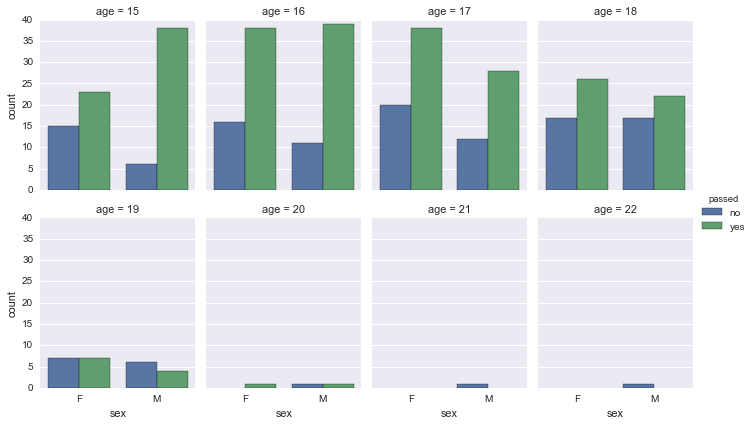

In [5]:
%matplotlib inline

_ = sns.factorplot("sex", col="age", col_wrap=4,
                   data = student_data, hue="passed",
                   kind = "count", size=3, aspect=.8)

In the above histograms we can see some clear gender differences in younger students when it comes to passing the final exam: boys are clearly doing a lot better than girls. By 16, they're about equal. By 18, we seem to be seeing something like "senioritis" setting in.

Also, surprising to see the older students. Wondering if these are some kind of GED students, or students who for whatever reason didn't pass at the normal age.

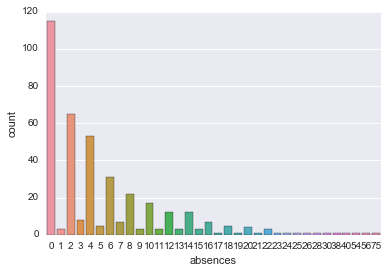

In [6]:
sns.countplot(student_data['absences'])

Interesting that our data shows these counts in absences. Appears to be some problem with the data collection in that it appears that some absences seem to be underreported.

Absences should be a good indicator for pass/failure. Clearly this is going to limit it's impact here.

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [7]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, we will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 76%) and 95 testing points (approximately 24%).
  - Set a `random_state` as needed.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [14]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into the number of training and testing points above
# We also want to maintain the same graduation rate between training and test sets by setting
# the test_size as a percentage of the full sample size and passing the target set to the
# stratify function
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all,
                                                    test_size=0.24, random_state=99)

print "Grad rate of the training set: {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Grad rate of the testing set: {:.2f}%".format(100 * (y_test == 'yes').mean())

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Grad rate of the training set: 67.00%
Grad rate of the testing set: 67.37%
Training set has 300 samples.
Testing set has 95 samples.


In [15]:
# As a test, we'll create a normalized version of the X_train and X_test sample sets to see if this improves our results

from sklearn.preprocessing import Normalizer

normer = Normalizer()
X_train2 = normer.fit_transform(X_train)
X_test2 = normer.transform(X_test)

## Training and Evaluating Models
In this section, we will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. We will first discuss the reasoning behind choosing these three models by considering what we know about the data and each model's strengths and weaknesses. We will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. We will then produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

We want to select classification algorithms that are robust with datasets that have fairly large feature sets, but also have a small number of samples by comparison, like our dataset for this project. We also want to select algorithms that have low overhead memory and computation requirements as per the school board's design brief to minimize computation costs. We also want algorithms that can be readily tuned to yield the best optimization.

However, we should anticipate the need to scale the algorithm to much larger datasets as the school continues adding students to it's roll, so selecting for algorithms that scale effectively should be a consideration as well.

Support Vector Machines are good out of the box algorithms classfication problems: low sample size, large feature set, low overhead, flexible tuning capabilities. This seems to be a good algorithm to start any classification problem with.

However, SVMs don't scale very well, so it might be better to replace the standard SVC algorithm from SKLearn with the LinearSVC.

Another go-to classifier is the KNearestNeighbors algorithm. This one has low overhead and predicts quickly, but that drops off quickly as sample size scales. However, with careful tuning, good results on both fronts can be achieved.

Finally, another classifier to test is Stochastic Gradient Descent, which is a very efficient learner with lots of tuning capabilities for improving predictive performance. Additionally, it scales very well with increasing sample sizes, in fact it prefers larger datasets to smaller ones.

### Setup
Run the code cell below to initialize three helper functions which can be used for training and testing the three supervised learning models selected above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [16]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__,
                                                                      len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, we will now import the three supervised learning models and run the `train_predict` function for each one.

In [17]:
# Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# TODO: Initialize the three models
clf_A = KNeighborsClassifier()
clf_B = SGDClassifier(random_state = 99)
clf_C = SVC(random_state = 10)

# TODO: Execute the 'train_predict' function for each classifier and each training set size
for clf in [clf_A, clf_B, clf_C]:
    print "\n{}: \n".format(clf.__class__.__name__)
    for n in [100, 200, 300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print"\n"


KNeighborsClassifier: 

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8088.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7576.


Training a KNeighborsClassifier using a training set size of 200. . .
Trained model in 0.0000 seconds
Made predictions in 0.0030 seconds.
F1 score for training set: 0.8271.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.7724.


Training a KNeighborsClassifier using a training set size of 300. . .
Trained model in 0.0000 seconds
Made predictions in 0.0060 seconds.
F1 score for training set: 0.8682.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.7626.



SGDClassifier: 

Training a SGDClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.7654.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.8050

### Tabular Results
The tables below show the above results a bit more clearly.

** Classifer 1 - KNeighborsClassifier   

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: ||
| 100               |0.0010|0.0020|0.8088|0.7576|
| 200               |0.0000|0.0020|0.8271|0.7724|
| 300               |0.0010|0.0020|0.8682|0.7626|

** Classifer 2 - SGDClassifier   

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |0.0010|0.0000|0.7654|0.8050|
| 200               |0.0000|0.0000|0.8025|0.8322|
| 300               |0.0010|0.0000|0.8082|0.8258|

** Classifer 3 - SVC   

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |0.0010|0.0010|0.8571|0.7887|
| 200               |0.0040|0.0010|0.8599|0.8077|
| 300               |0.0060|0.0020|0.8811|0.7919|

In [18]:
from sklearn.metrics import classification_report

for clf in [clf_A, clf_B, clf_C]:
    print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

         no       0.45      0.29      0.35        31
        yes       0.71      0.83      0.76        64

avg / total       0.62      0.65      0.63        95

             precision    recall  f1-score   support

         no       1.00      0.13      0.23        31
        yes       0.70      1.00      0.83        64

avg / total       0.80      0.72      0.63        95

             precision    recall  f1-score   support

         no       0.50      0.16      0.24        31
        yes       0.69      0.92      0.79        64

avg / total       0.63      0.67      0.61        95



## Choosing the Best Model
According to the results above, it looks like the SGDClassifier is the favorite here. It is the only one the ended up beating our benchmark of 0.8030 while also requiring low computational resources.

KNN and SVC simply don't measure up as they can't even beat the benchmark. Additionally, SVC increasing training times with increasing sample sizes.

As another check, I tried Gaussian Naive Bayes classifier as well, but it fared worse than KNN.

# Summarizing the Chosen Model for the Board

The Stochastic Gradient Descent classifier works by cycling through a process of repeatedly trying to minimize the difference between a prediction and the actual result. In this case, the prediction is created by trying to draw a line (well, actually a plane, but we'll just call it a line for simplicity) between the passes and the fails and using that line as our prediction boundary: results on one side of the line are passes, the other side fails.

The difference between our prediction of students who passed and the actual number of students who passed is called the error function or cost function. Our classifer function minimizes this cost function by increasing or decreasing different "weights" that are multiplied with the various features - famsize or studytime, for instance - and adding these products together to form the equation of the line that will be used to separate the passes from the fails. It then compares these pass/fail predictions against the actual result. It compares these differences from each pass to see if the differences are getting larger or smaller. It will change the weights, recalculate, and compare again. While it performs this process, it keeps score so as to track how well it's predicting is doing based on the calculated weights that it is assigning to each feature. It keeps modifying the weights for each feature so as to keep increasing this score. It will repeat this process using the entire sample set until it runs through a set number of iterations to perform at which point it shows us the score it calculated and the various weights it assigned to the different features.

With this information we can then continue to fine tune the Stochastic Gradient Descent classifier to achieve a better score as well as to see which features are having the greatest influence on a higher score.

### Implementation: Model Tuning
Fine tune the chosen model. 

In [19]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
#parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1]}
#parameters = {'alpha':[1, 2, 3, 4, 5]}
#parameters = {'alpha':[2.05,2.07,2.1,2.13,2.15]}
#parameters = {'alpha':[2.045,2.05,2.055]}
#parameters = {'loss':('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')}
#parameters = {'penalty':('l2','l1','elasticnet'),
#              'loss':('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
#              'alpha':[1, 2, 3, 4, 5]}
parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1),
              'n_iter': (5, 100, 500, 1000, 3000)}

# TODO: Initialize the classifier
# Here we want to use the same random_state as the untuned classifier
clf = SGDClassifier(random_state =99)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label = 'yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0010 seconds.
Tuned model has a training F1 score of 0.8195.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.8421.


In [20]:
clf

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=500, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=99, shuffle=True, verbose=0,
       warm_start=False)

In [21]:

parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1),
              'n_iter': (5, 100, 500, 1000, 3000)}

# TODO: Initialize the classifier
clf2 = SGDClassifier(random_state =99)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label = 'yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj2 = GridSearchCV(clf2, parameters, f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj2 = grid_obj2.fit(X_train2, y_train)

# Get the estimator
clf2 = grid_obj2.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf2, X_train2, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf2, X_test2, y_test))

Made predictions in 0.0010 seconds.
Tuned model has a training F1 score of 0.8210.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.8392.


In [22]:
clf2

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=3000, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=99, shuffle=True, verbose=0,
       warm_start=False)

Oh well: it appears normalizing didn't do much for us.

### Final F<sub>1</sub> Score
The final model's F1 score for training is 0.8195 and for testing is 0.8421.

This tuned model is a bit better than our untuned result, which is encouraging. Putting more work into finer tuning is clearly warranted here.